## Import neccessary libraries

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


## Read data

In [2]:
data = pd.read_csv('alonhadat-CLEAN2.csv', encoding='utf-8')

In [3]:
data.head()

,description,area,direction,dining_room,road_width,kitchen,house_type,land_use_rights,rooftop,width,storey,car_parking,length,bedroom,road,ward,district,price,X,Y
0,"Cần bán nhà Lê Trọng Tấn,Hà đông\n+Vị trí đẹp,...",40.0,NaN,NaN,7.0,NaN,Nhà trong hẻm,Sổ hồng/ Sổ đỏ,NaN,NaN,4,NaN,NaN,3.0,lê trọng tấn,la khê,hà đông,5.95,20.967015,105.756479
1,Cần bán nhà phố Ao sen-Hà đông\n-Vị trí đắc đị...,40.0,NaN,NaN,11.0,NaN,Nhà mặt tiền,NaN,NaN,NaN,5,NaN,NaN,3.0,ao sen,mộ lao,hà đông,10.45,20.982356,105.787992
2,"Bán gấp nhà xóm chùa Xa la,Hà đông.Nhà gần việ...",40.0,NaN,NaN,5.0,NaN,Nhà trong hẻm,Sổ hồng/ Sổ đỏ,NaN,NaN,4,NaN,NaN,4.0,xa la,kiến hưng,hà đông,4.90,20.960122,105.800079
3,"-Bán nhà khu Cổng đồng La khê,Hà đông.Vị trí đ...",50.0,NaN,NaN,11.0,NaN,"Biệt thự, nhà liền kề",Sổ hồng/ Sổ đỏ,NaN,NaN,6,NaN,NaN,4.0,tố hữu,la khê,hà đông,7.45,20.970769,105.755225
4,Cần bán gấp nhà mặt phố Phan Đình Phùng Hà đôn...,60.0,NaN,NaN,17.0,NaN,Nhà mặt tiền,Sổ hồng/ Sổ đỏ,NaN,NaN,5,NaN,NaN,4.0,phan đình phùng,yết kiêu,hà đông,12.30,20.972974,105.776924


### Some initial processing

In [4]:
data.drop(data[data['area'].isnull()].index, inplace=True)
data.drop(data[data['price'].isnull()].index, inplace=True)
data.drop(data[data['area']<=0].index, inplace=True)
data.drop(data[data['length']<=0].index, inplace=True)
data.drop(data[data['width']<=0].index, inplace=True)

#calculate price per m2
data['price_per_m2'] = data['price']*1000/data['area']

data.drop('description', axis=1, inplace=True)

#handle some obvious outliers for price_per_m2
data.drop(data[data['price_per_m2']>1500].index, inplace=True)

data.replace('Null', np.nan, inplace=True)
data.replace('NULL', np.nan, inplace=True)
data['storey'].replace('---', np.nan, inplace=True)
data['storey'] = data['storey'].astype(float)
data.drop(data[data['storey']>90].index, inplace=True)

data.reset_index(drop=True, inplace=True)

## Explore **price** column 

<AxesSubplot:>

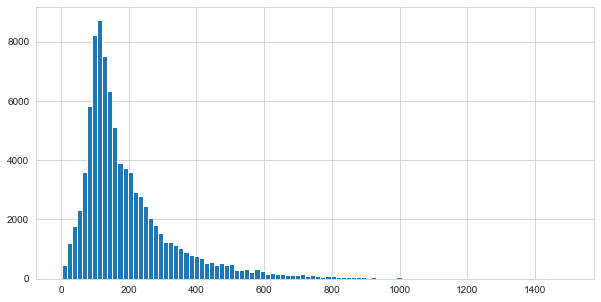

In [5]:
#plot histogram for price_per_m2
data['price_per_m2'].hist(bins=100, figsize=(10,5))

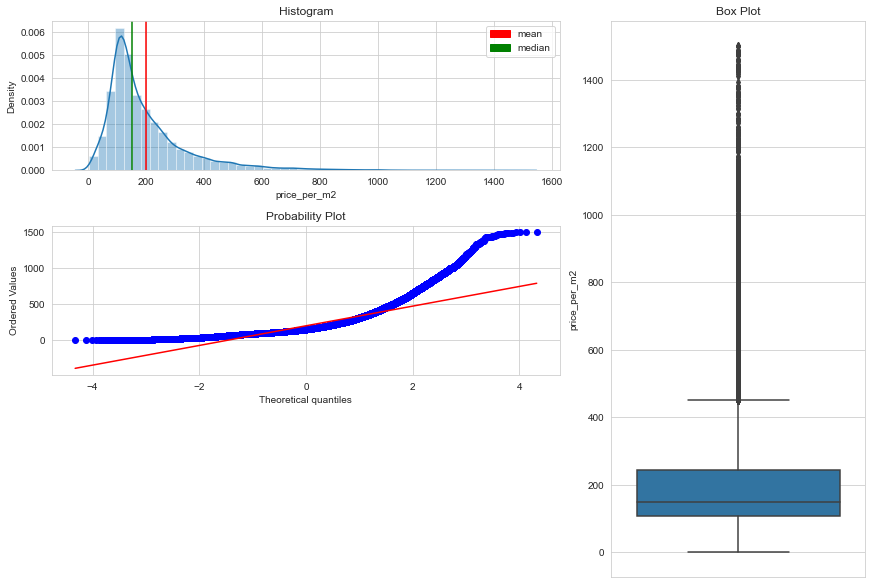

In [6]:
#import mpatches
import matplotlib.patches as mpatches
def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True,ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')
    # set legend for red and green line
    red_patch = mpatches.Patch(color = 'red', label = 'mean')
    green_patch = mpatches.Patch(color = 'green', label = 'median')
    plt.legend(handles = [red_patch, green_patch])
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    sns.boxplot(y=df[feature], ax = ax3 )
    
three_chart_plot(data, 'price_per_m2')


From the above plots, we can observe that the price_per_m2 is not normally distributed. From the boxplot we can observe that the dataset have a number of outliers.

For the probability plot, the red line represents those points which would have been plotted for y-axis points if those were normally distributed. But the blue points represents the actual scenario. We can see that there is a lot of deviation on the both the ends i.e on the top right and bottom left.

As the mean of the feature is greater than the median which is greater than the mode and the line is flat towards the right in the histogram, the given feature is Positively Skewed. Most of the houses were sold less than the average price.



In [7]:
from scipy.stats import skew
print("Skewness of the SalesPrice is", data['price_per_m2'].skew())

Skewness of the SalesPrice is 2.439848017653585


## Explore missing data

<AxesSubplot:>

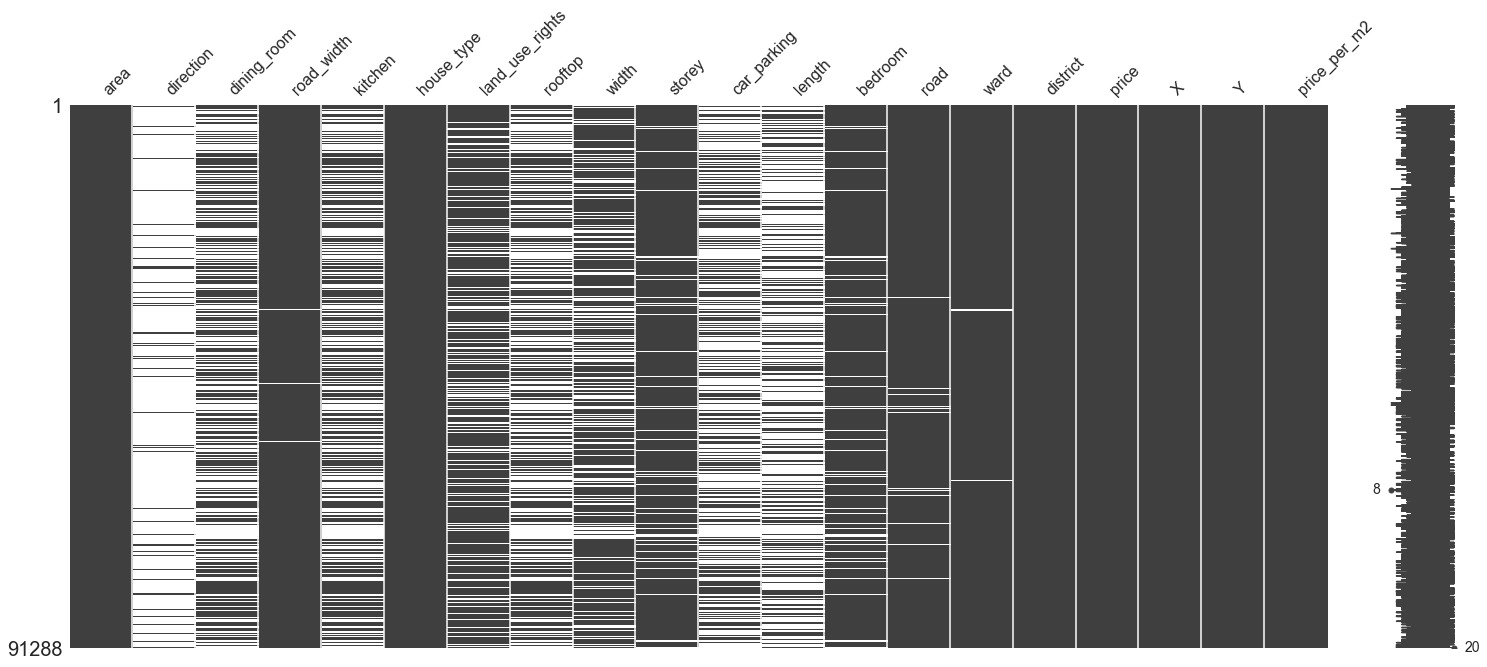

In [8]:
import missingno as msno
%matplotlib inline
msno.matrix(data)

We can see that the data has a lot of missing data. We will have a closer look at these missing values

In [9]:
def null_table(data):
    """
    A function which returns the number and percentage of null values in the given dataset.
    """
    indices = data.isnull().sum().index
    values = data.isnull().sum().values
    percentages = []
    for i in indices:
        percentages.append((data[i].isnull().sum() / data[i].shape[0]) * 100)
    d = {'Columns' : indices, 'Count of Null Values' : values, 'Approximate Percentage of Null Values' : percentages}
    # data = dict(zip(indices, percentages))
    null_frame = pd.DataFrame(data = d)
    return null_frame
null_frame_train = null_table(data)
null_frame_train.sort_values(by = 'Approximate Percentage of Null Values').tail(20)


,Columns,Count of Null Values,Approximate Percentage of Null Values
0,area,0,0.000000
17,X,0,0.000000
16,price,0,0.000000
15,district,0,0.000000
18,Y,0,0.000000
19,price_per_m2,0,0.000000
5,house_type,0,0.000000
14,ward,386,0.422838
3,road_width,565,0.618920
13,road,2194,2.403383


In [10]:
#split to train and test df 
indices = np.random.permutation(data.index)

# Calculate the split index based on the ratios
split_idx = int(len(data) * 0.7)

# Split the dataframe into train and test
train = data.iloc[indices[:split_idx]]
test = data.iloc[indices[split_idx:]]



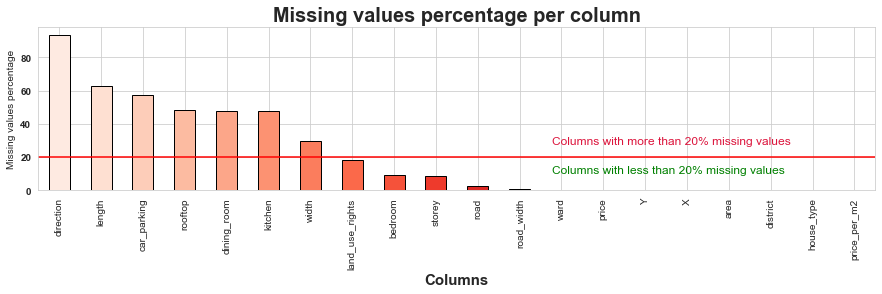

In [11]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

msv_1(train, 20, color=sns.color_palette('Reds',15))


Our data contains a lot of missing values. We will drop all row with missing values in at least three columns in list direction,length,car_parking,rooftop,dining_room,kitchen,width. 

In [12]:
#drop all row with missing values in at least three columns in list ['direction','length','car_parking','rooftop','dining_room','kitchen','width']
columns_to_check = ['direction', 'length', 'car_parking', 'rooftop', 'dining_room', 'kitchen', 'width']
threshold = len(columns_to_check) - 3  # Set the threshold for missing values

df_cleaned = data.dropna(subset=columns_to_check, thresh=threshold)
len(df_cleaned)


45187

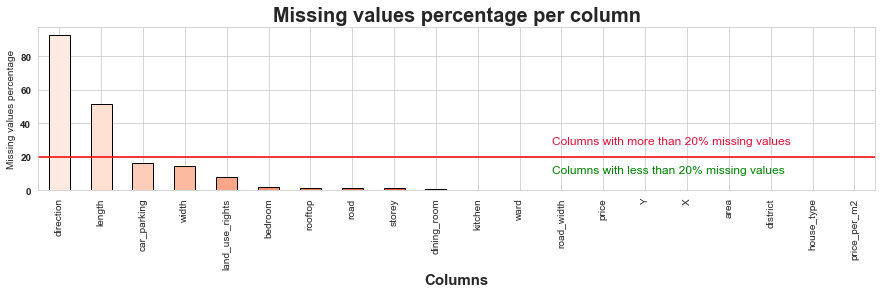

In [13]:
msv_1(df_cleaned, 20, color=sns.color_palette('Reds',15))


We can see that there is only direction and length columns that remain above 20% of missing values. We will deal with these later

### Missing values in **length** and **width** column

Hypothesis: Do length equal to area/width?

In [14]:
# We test the hypothesis that the length is equal to area/width
# H0: length = area/width
# H1: length != area/width
# We use the t-test for the mean of one sample
import scipy.stats as stats

#filter out the rows that have no missing values in any column length, width and area
df_cleaned_test = df_cleaned.dropna(subset=['length','width','area'], thresh=3)
stats.ttest_rel(df_cleaned_test['length'], df_cleaned_test['area']/df_cleaned_test['width'])


TtestResult(statistic=2.3159602584716126, pvalue=0.020569698085989872, df=21730)

The p-value is much smaller than 0.05, which means that we must reject the null hypothesis. There is no equal relation between length and area/width

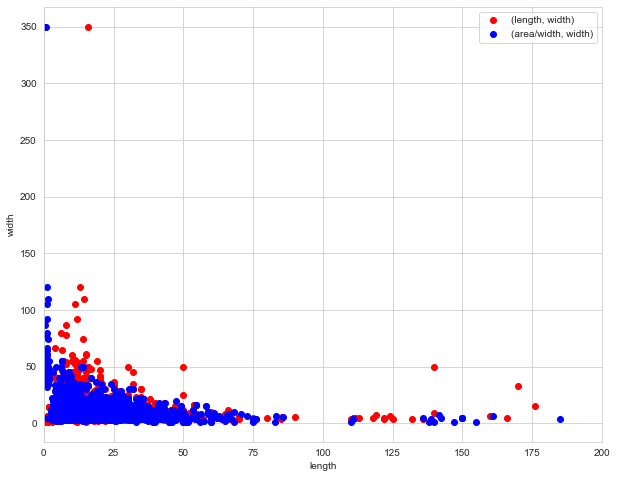

In [15]:
#Plot the scatterplot with red point is (length, width) and blue point is (area/width, width)
plt.figure(figsize=(10,8))
plt.scatter(df_cleaned_test['length'], df_cleaned_test['width'], color='red')
plt.scatter(df_cleaned_test['area']/df_cleaned_test['width'], df_cleaned_test['width'], color='blue')
plt.xlabel('length')
plt.ylabel('width')
plt.legend(['(length, width)', '(area/width, width)'])
#limit the x-axis to 200
plt.xlim(0,200)
plt.show()

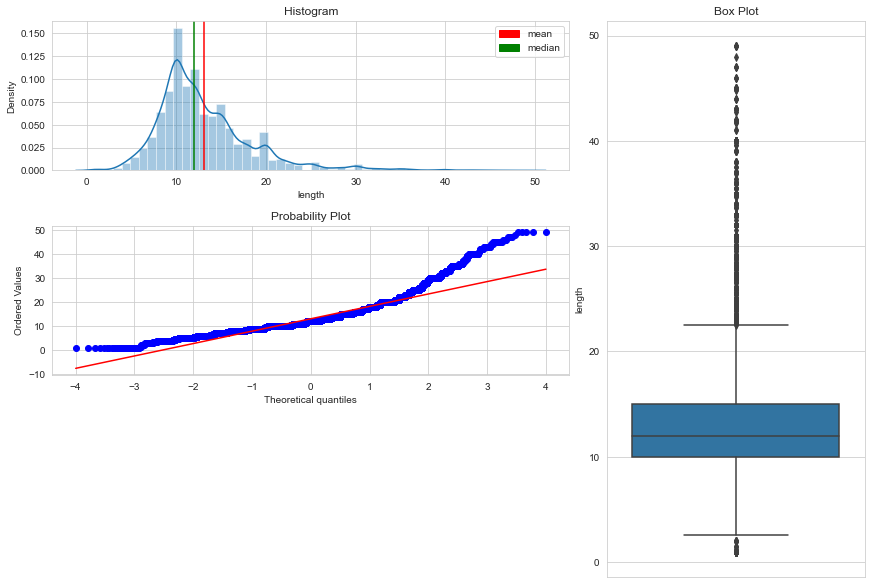

In [16]:
three_chart_plot(df_cleaned[df_cleaned['length']<50], 'length')


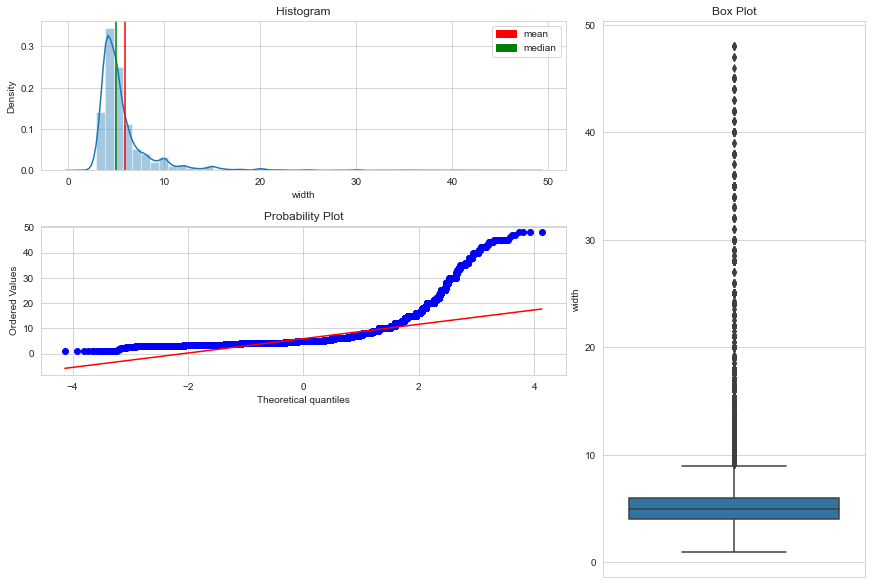

In [17]:
three_chart_plot(df_cleaned[df_cleaned['width']<50], 'width')


As these contains a lot of outliers, we will fill these column by median 

In [18]:
category_var = data.select_dtypes(include = 'object')
num_var = data.select_dtypes(exclude = 'object')

print("Number of categorical features are: ", category_var.shape[1])
print("Number of numerical features are: ", num_var.shape[1])


Number of categorical features are:  10
Number of numerical features are:  10


## Explore numerical columns

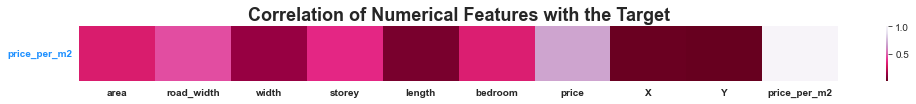

In [19]:
num = df_cleaned.select_dtypes(exclude = 'object')
corr_num = num.corr()

f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr_num.sort_values(by = ['price_per_m2'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlation of Numerical Features with the Target', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()


In [20]:
correlation = df_cleaned.corr()['price_per_m2'].sort_values(ascending = False).to_frame().head(10)

cmap = sns.light_palette("cyan", as_cmap = True)

s = correlation.style.background_gradient(cmap = cmap)

s

,price_per_m2
price_per_m2,1.000000
price,0.682449
road_width,0.460217
storey,0.371391
bedroom,0.326204
area,0.315185
width,0.135517
length,0.063743
X,0.025600
Y,0.014497


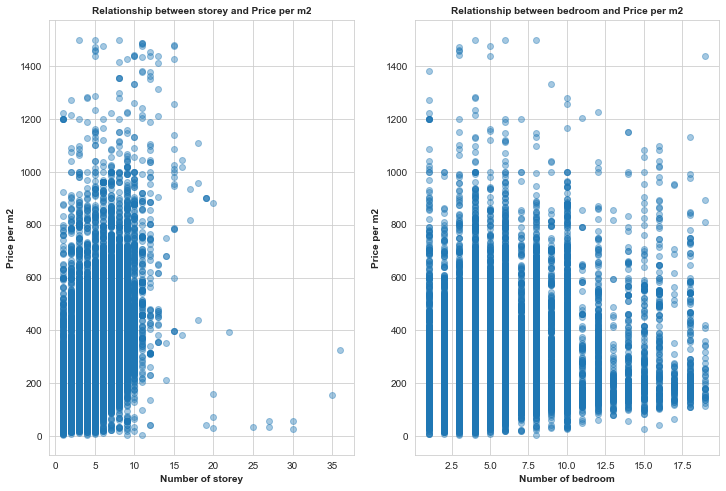

In [21]:
fig, (ax1, ax2) = plt.subplots(figsize = (12, 8), ncols = 2,sharey = False)
ax1.scatter(x = 'storey', y = 'price_per_m2', data = df_cleaned[df_cleaned['storey']<40],  alpha=0.4)
ax1.set_title('Relationship between storey and Price per m2', weight = 'bold', fontsize = 10)
ax1.set_xlabel('Number of storey', weight = 'bold')
ax1.set_ylabel('Price per m2', weight = 'bold')
ax2.scatter(x = 'bedroom', y = 'price_per_m2', data = df_cleaned[df_cleaned['bedroom']<20],  alpha=0.4)
ax2.set_title('Relationship between bedroom and Price per m2', weight = 'bold', fontsize = 10)
ax2.set_xlabel('Number of bedroom', weight = 'bold')
ax2.set_ylabel('Price per m2', weight = 'bold')

plt.show()


<AxesSubplot:xlabel='road_width', ylabel='price_per_m2'>

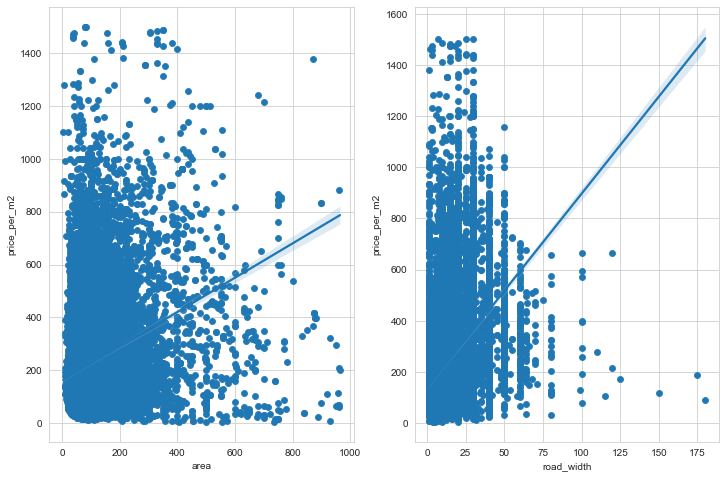

In [23]:
## Scatter plotting for SalePrice and GrLivArea.
fig, (ax1, ax2) = plt.subplots(figsize = (12, 8), ncols = 2,sharey = False)
 
sns.scatterplot(x = df_cleaned['area'], y = df_cleaned['price_per_m2'],  ax = ax1)
## Putting a regression line. 
sns.regplot(x = df_cleaned['area'], y = df_cleaned['price_per_m2'], ax = ax1)

sns.scatterplot(x = df_cleaned[df_cleaned['road_width']<200]['road_width'],y = df_cleaned[df_cleaned['road_width']<200]['price_per_m2'], ax = ax2)
## regression line for MasVnrArea and SalePrice. 
sns.regplot(x = df_cleaned[df_cleaned['road_width']<200]['road_width'], y = df_cleaned[df_cleaned['road_width']<200]['price_per_m2'], ax=ax2)


A residual plot is a type of plot that displays the fitted values of a regression model on the x-axis and the residuals of the model along the y-axis.

<AxesSubplot:xlabel='storey', ylabel='price_per_m2'>

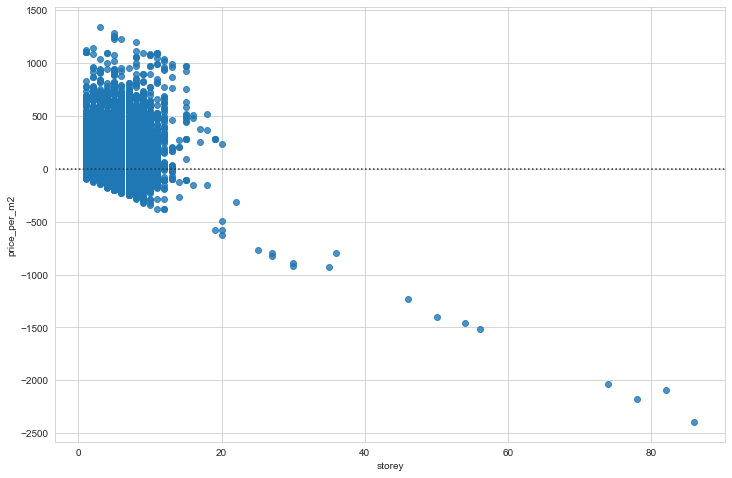

In [22]:
plt.subplots(figsize = (12,8))
sns.residplot(df_cleaned['storey'], df_cleaned['price_per_m2'])


Ideally, if the assumptions are met, the residuals will be randomly scattered around the centerline of zero with no apparent pattern. The residual will look like an unstructured cloud of points centered around zero. However, our residual plot is anything but an unstructured cloud of points.

The error plot shows that as storey value increases, the variance also increases, which is the characteristics known as Heteroscedasticity. The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed.



We will do log transform for target variable to get a more normal distribution

In [23]:
df_cleaned['price_per_m2_log'] = np.log1p(df_cleaned['price_per_m2'])

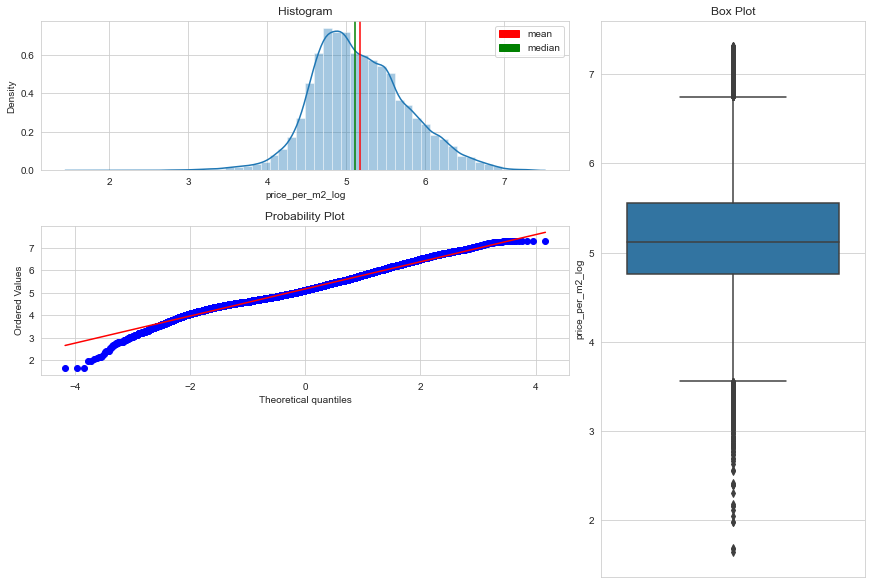

In [24]:
three_chart_plot(df_cleaned, 'price_per_m2_log')

We can observe that the price_per_m2 feature now follows a normal distibution as the Histogram resembles bell-shape and the QQ-plot also overlaps with the red line. Let's again plot the scatter plot for storey and price_per_m2 to see whether Heteroscedasticity was removed.



<AxesSubplot:xlabel='storey', ylabel='price_per_m2_log'>

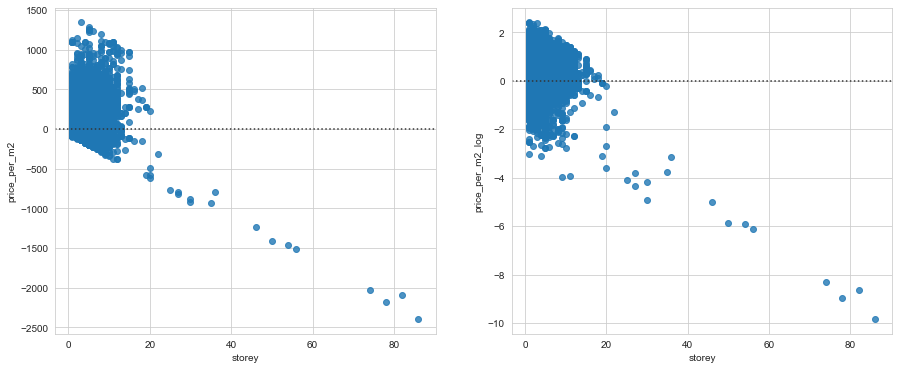

In [25]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6),
                              ncols = 2,
                              sharey = False,
                              sharex = False)

sns.residplot(df_cleaned['storey'], df_cleaned['price_per_m2'], ax = ax1)
sns.residplot(df_cleaned['storey'], df_cleaned['price_per_m2_log'], ax = ax2)


We can see that the scatterplot on the left had heteroscedasticity(funnel like shape) but after applying log transformation to the feature, it was removed and now it's Homoscedastic.



<AxesSubplot:xlabel='area', ylabel='price_per_m2_log'>

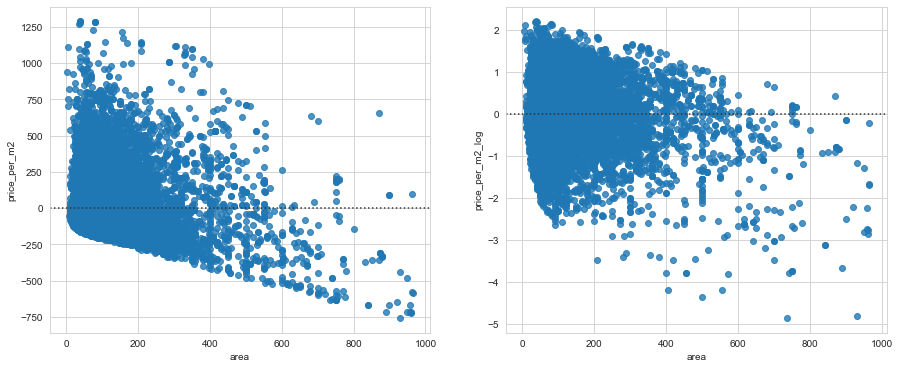

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6),
                              ncols = 2,
                              sharey = False,
                              sharex = False)

sns.residplot(df_cleaned['area'], df_cleaned['price_per_m2'], ax = ax1)
sns.residplot(df_cleaned['area'], df_cleaned['price_per_m2_log'], ax = ax2)


## Explore categorical variables

### Bar graph for most occurrences in categorical variables

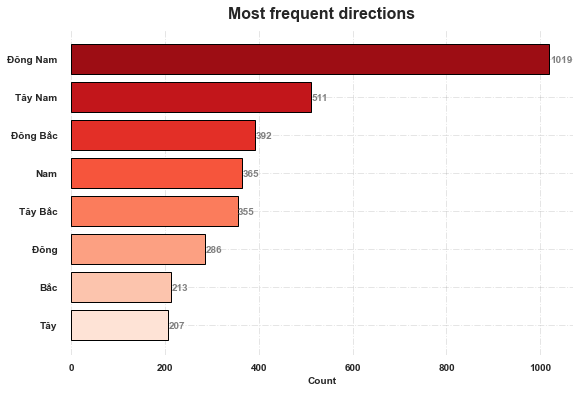

In [27]:
def horizontal_plot(data, column_name, color, plot_title, log=False):
    
    """
    A function that plots a horizontal bar graph for the given column name
    """
    
    fig, ax = plt.subplots(figsize = (9, 6))
    
    title_cnt = data[column_name].value_counts().sort_values(ascending = False).reset_index()
    if log == True:
        title_cnt.iloc[:, 1] = np.log(title_cnt.iloc[:, 1])
    color_palette = sns.color_palette(color, len(title_cnt))
    color_palette.reverse()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                color_palette)

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 
    ax.invert_yaxis()

    ax.set_title(plot_title,weight='bold',loc='center', pad=10, fontsize=16)
    
    ax.set_xlabel('Count', weight='bold')

    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()
horizontal_plot(df_cleaned, 'direction', 'Reds', 'Most frequent directions')


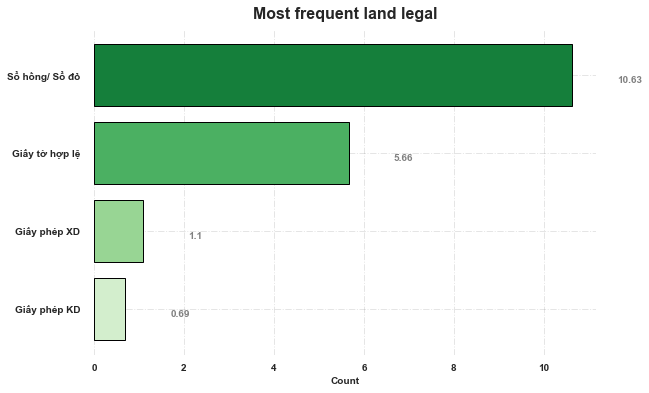

In [28]:
horizontal_plot(df_cleaned, 'land_use_rights', 'Greens', 'Most frequent land legal', log = True)


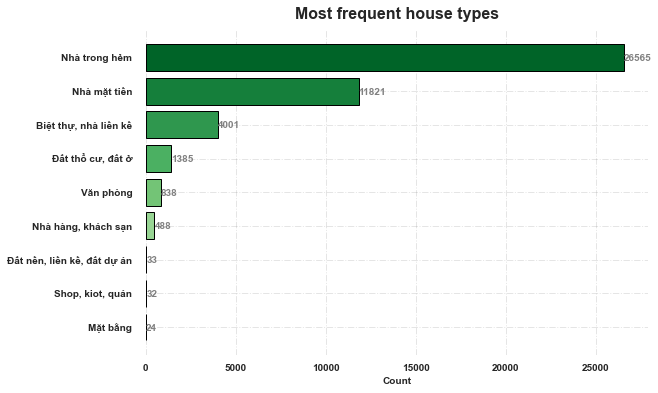

In [29]:
horizontal_plot(df_cleaned, 'house_type', 'Greens', 'Most frequent house types', log = False)


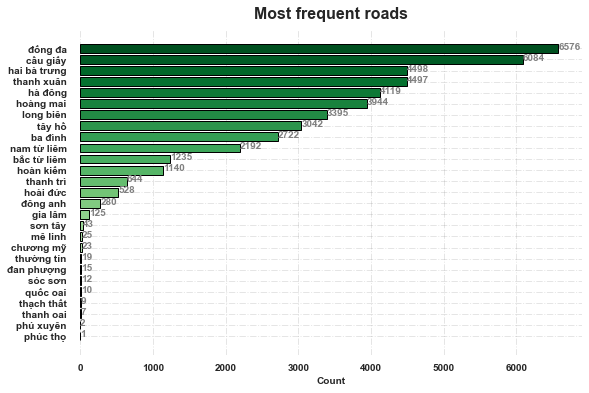

In [30]:
horizontal_plot(df_cleaned, 'district', 'Greens', 'Most frequent roads', log = False)


### Bar graph for average house price for each categorical columns

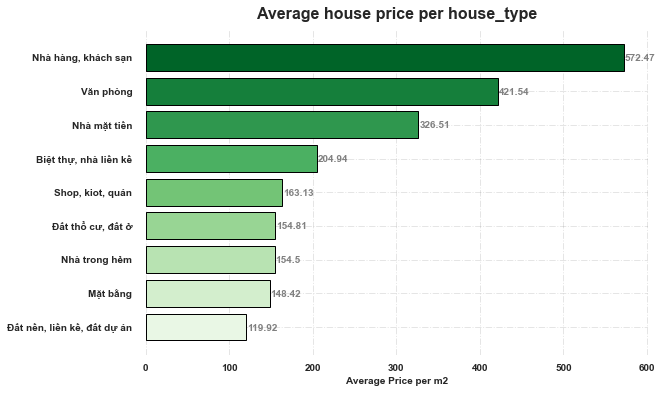

In [31]:
def plot_avg_price_per_cat_column(column_name, color = 'Greens'):
    
    """
    A function that plots a horizontal bar graph for the given column name
    """

    fig, ax = plt.subplots(figsize = (9, 6))
    title_cnt = df_cleaned.groupby(column_name)['price_per_m2'].mean().sort_values(ascending = False).reset_index()
    color_pallete = sns.color_palette(color, len(title_cnt))
    color_pallete.reverse()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                color_pallete)

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 
    ax.invert_yaxis()

    ax.set_title(f"Average house price per {column_name}",weight='bold',loc='center', pad=10, fontsize=16)
    
    ax.set_xlabel('Average Price per m2', weight='bold')

    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()
plot_avg_price_per_cat_column("house_type")


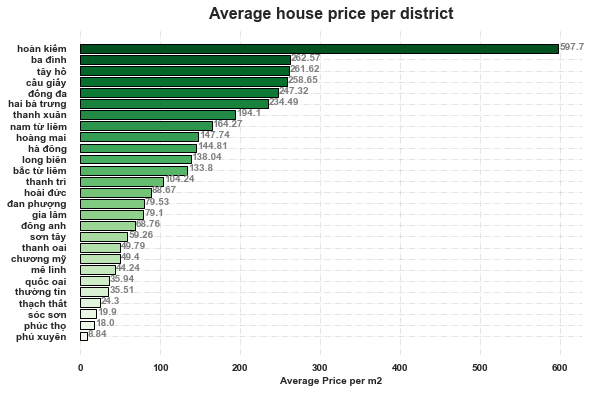

In [32]:
plot_avg_price_per_cat_column("district")


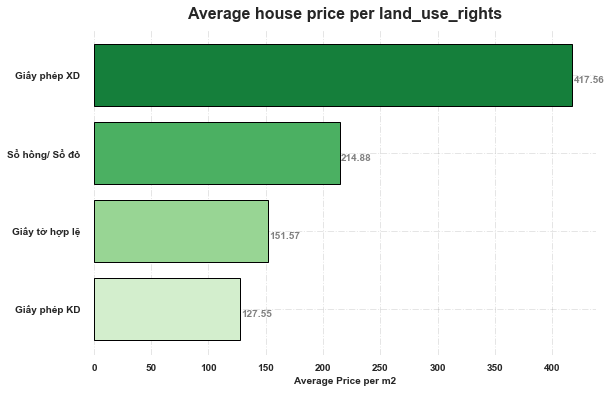

In [33]:
plot_avg_price_per_cat_column("land_use_rights")


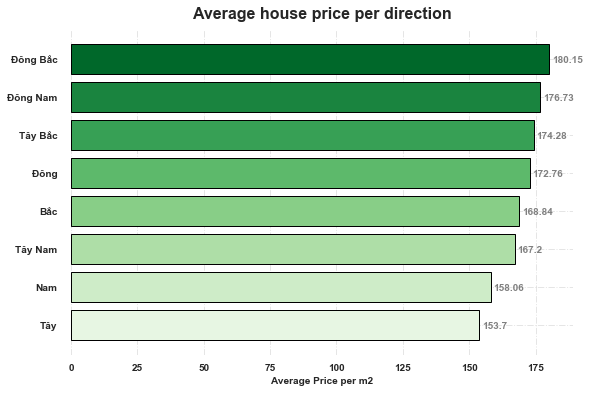

In [34]:
plot_avg_price_per_cat_column("direction")


## Bivariate analysis

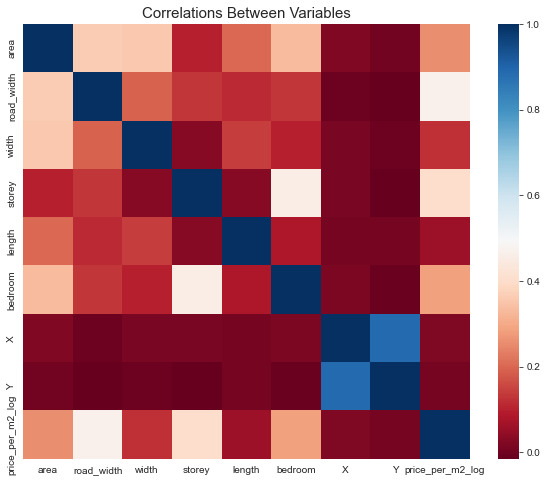

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cleaned[['area','road_width','width','storey','length','bedroom','X','Y','price_per_m2_log']].corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

We can see that except X and Y, there is no pair of variables with great correlation, which means there might not be strong linear relationships between any two individual variables. 

## Create Hanoi Real Estate map

In [23]:
#plot map based on X and Y - the longitude and latitude
import folium
from folium.plugins import HeatMap
from branca.colormap import LinearColormap

df_cleaned_sample = df_cleaned.sample(5000)
df_cleaned_sample = df_cleaned_sample.sort_values(by='price_per_m2', ascending=True)

colormap = LinearColormap(
    colors=['green', 'yellow', 'red'],
    vmin=df_cleaned_sample['price_per_m2'].min(),
    vmax=df_cleaned_sample['price_per_m2'].max()
)

# Create the map
m = folium.Map(location=[df_cleaned_sample['X'].mean(), df_cleaned_sample['Y'].mean()], zoom_start=5)

# Add markers with different colors based on price_per_m2
for index, row in df_cleaned_sample.iterrows():
    folium.CircleMarker(
        location=[row['X'], row['Y']],
        radius=5,  # You can adjust the radius of the dots as needed
        popup=f"Price/m2: {row['price_per_m2']}",
        fill=True,
        color=colormap(row['price_per_m2']),
        fill_opacity=0.7
    ).add_to(m)


# Add the colormap to the map
colormap.caption = 'price per m2'
m.add_child(colormap)

# Save the map
m.save('map_with_colored_markers.html')





### Encoding location (already done)

In [67]:
'''
from geopy.geocoders import Nominatim
import time
from tqdm import tqdm

def get_loc(x, lat=True):
    x = str(x)
    x_clean = x.replace(","," ")
    try:
        x_clean.replace("None", "")
        loc = Nominatim(user_agent="GetLoc")
        getLoc = loc.geocode(x_clean)
        return (  getLoc.latitude, getLoc.longitude)
    except:
        try:
            x = ','.join(x.split(',')[1:])
            x_clean = x.replace(","," ")
            x_clean.replace("None", "")
            loc = Nominatim(user_agent="GetLoc")
            getLoc = loc.geocode(x_clean)
            return (  getLoc.latitude, getLoc.longitude)
        except:
            try: 
                x = ','.join(x.split(',')[1:])
                x_clean = x.replace(","," ")
                x_clean.replace("None", "")
                loc = Nominatim(user_agent="GetLoc")
                getLoc = loc.geocode(x_clean)
                return (  getLoc.latitude, getLoc.longitude)
            except:
                loc = Nominatim(user_agent="GetLoc")
                getLoc = loc.geocode("Hà Nội")
                return (  getLoc.latitude, getLoc.longitude)
'''

In [63]:
'''
address = [1 for i in range(len(df_cleaned))]
for i in range(len(df_cleaned)):
    address[i] = str(df_cleaned["road"][i]) + "," + str(df_cleaned["ward"][i]) +"," + str(df_cleaned["district"][i])+ " hà nội"
    if str(address[i]) == 'nan':
        address[i] = str(df_cleaned["ward"][i]) +"," + str(df_cleaned["district"][i])+ " hà nội"
        if str(address[i]) == 'nan':
            address[i] = str(df_cleaned["district"][i])+ " hà nội"
            if str(address[i]) == 'nan':
                address[i] = "hà nội"   
'''

In [71]:
'''with open("geopy_loc/total_dict.pickle", "rb") as f:
    total_dict = pickle.load(f)
df_cleaned['X'] = 0
df_cleaned['Y'] = 0
for i in tqdm(range(len(df_cleaned))):
    if address[i] in total_dict.keys():
        df_cleaned['X'][i] = total_dict[address[i]][0]
        df_cleaned['Y'][i] = total_dict[address[i]][1] 
    else:
        try:
            df_cleaned['X'][i], df_cleaned['Y'][i]= get_loc(address[i])
            total_dict[address[i]] = [df_cleaned['X'][i], df_cleaned['Y'][i]]
        except:
            df_cleaned['X'][i], df_cleaned['Y'][i]= get_loc('Hà Nội')
            total_dict['Hà Nội'] = [df_cleaned['X'][i], df_cleaned['Y'][i]]
'''

In [36]:
df_cleaned.to_csv('alonhadat-CLEAN3.csv', index=False)

In [3]:
df_cleaned = pd.read_csv('alonhadat-CLEAN3.csv', encoding='utf-8')

## Data Engineering

### Handle missing values

<AxesSubplot:>

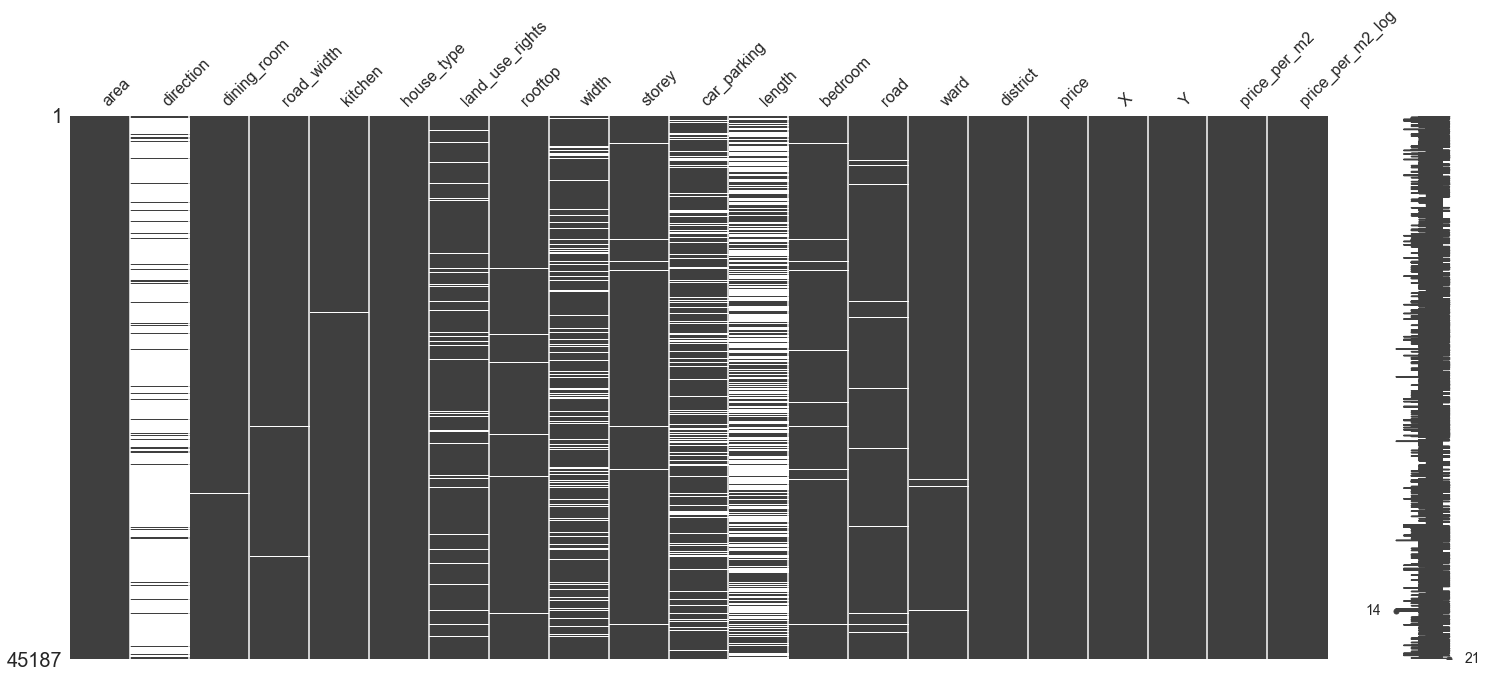

In [4]:
import missingno as msno
%matplotlib inline
msno.matrix(df_cleaned)

In [5]:
df_cleaned['direction']= df_cleaned['direction'].astype(str)
df_cleaned['house_type']= df_cleaned['house_type'].astype(str)
df_cleaned['land_use_rights']= df_cleaned['land_use_rights'].astype(str)


In [6]:
train, test = train_test_split(df_cleaned, test_size=0.2, random_state=42,stratify=df_cleaned['house_type'])

In [7]:
#Handle missing values for numerical columns
train['storey'].fillna(train['storey'].median(), inplace=True)
train['length'].fillna(train['length'].median(), inplace=True)
train['width'].fillna(train['width'].median(), inplace=True)
train['area'].fillna(train['area'].median(), inplace=True)
train['bedroom'].fillna(train['bedroom'].median(), inplace=True)
train['road_width'].fillna(train['road_width'].median(), inplace=True)

test['storey'].fillna(train['storey'].median(), inplace=True)
test['length'].fillna(train['length'].median(), inplace=True)
test['width'].fillna(train['width'].median(), inplace=True)
test['area'].fillna(train['area'].median(), inplace=True)
test['bedroom'].fillna(train['bedroom'].median(), inplace=True)
test['road_width'].fillna(train['road_width'].median(), inplace=True)


In [8]:
#Handle missing values for categorical columns
train['direction'].fillna('None', inplace=True)
train['dining_room'].fillna(train['dining_room'].mode()[0], inplace=True)
train['kitchen'].fillna(train['kitchen'].mode()[0], inplace=True)
train['car_parking'].fillna(train['car_parking'].mode()[0], inplace=True)
train['land_use_rights'].fillna(train['land_use_rights'].mode()[0], inplace=True)
train['rooftop'].fillna(train['rooftop'].mode()[0], inplace=True)

test['direction'].fillna('None', inplace=True)
test['dining_room'].fillna(train['dining_room'].mode()[0], inplace=True)
test['kitchen'].fillna(train['kitchen'].mode()[0], inplace=True)
test['car_parking'].fillna(train['car_parking'].mode()[0], inplace=True)
test['land_use_rights'].fillna(train['land_use_rights'].mode()[0], inplace=True)
test['rooftop'].fillna(train['rooftop'].mode()[0], inplace=True)


### Handle outliers

In [9]:
#Handle outliers that exceed Q3 + 1.5*IQR and Q1 - 1.5*IQR
def handle_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df.drop(df[df[column_name] > (Q3 + 1.5*IQR)].index, inplace=True)
    df.drop(df[df[column_name] < (Q1 - 1.5*IQR)].index, inplace=True)
    return df

In [10]:
train = handle_outliers(train, 'area')
train = handle_outliers(train, 'storey')
train = handle_outliers(train, 'road_width')
train = handle_outliers(train, 'length')
train = handle_outliers(train, 'width')
train = handle_outliers(train, 'bedroom')
train = handle_outliers(train, 'price_per_m2_log')


### Scaling

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

In [12]:
scaler = RobustScaler()
scale_feat = ['area', 'length', 'width', 'road_width']
train[scale_feat] = scaler.fit_transform(train[scale_feat])
test[scale_feat] = scaler.transform(test[scale_feat])

In [13]:
scaler = MinMaxScaler()
scale_feat = ['X', 'Y']
train[scale_feat] = scaler.fit_transform(train[scale_feat])
test[scale_feat] = scaler.transform(test[scale_feat])

### Encoding categorical variables

In [14]:
#encode categorical features by one hot encoding
train = pd.get_dummies(train, columns=['direction', 'house_type', 'land_use_rights'])
test = pd.get_dummies(test, columns=['direction', 'house_type', 'land_use_rights'])


In [15]:
test['land_use_rights_Giấy phép KD'] = 0

In [16]:
not_features = ['price', 'road', 'ward', 'district','price_per_m2','price_per_m2_log']
features = [col for col in train.columns if col not in not_features]

In [17]:
features = ['area', 'road_width', 'width', 'storey', 'length',
 'bedroom', 'X', 'Y','direction_Nam',
 'direction_nan','direction_Đông','direction_Đông Nam', 'house_type_Biệt thự, nhà liền kề', 'house_type_Mặt bằng',
 'house_type_Nhà mặt tiền', 'house_type_Nhà trong hẻm', 'house_type_Shop, kiot, quán',
 'house_type_Đất nền, liền kề, đất dự án', 'house_type_Đất thổ cư, đất ở','land_use_rights_Giấy tờ hợp lệ',
 'land_use_rights_Sổ hồng/ Sổ đỏ']

### Define metrics

In [28]:
from sklearn.metrics import mean_absolute_percentage_error as mape,r2_score, mean_squared_error as mse

def print_metrics(y_true, y_pred, log = False):
    print('R2:', r2_score(y_true, y_pred))
    #take reverse log of y_pred
    if log:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    print('RMSE:', np.sqrt(mse(y_true, y_pred)))
    print('MAPE:', mape(y_true, y_pred))


Metrics used: 
- Mean absolute percentage error: 
- Mean squared error:
- R2 score

##  Modelling

### Tree-based model

In [19]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators = 600, max_depth=20, eta=0.01, gamma=1, tree_method="gpu_hist",subsample=1, 
    objective="reg:squarederror", enable_categorical=True, random_state=0)


In [20]:
xgb.fit(train[features], train['price_per_m2_log']) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True, eta=0.01,
             eval_metric=None, gamma=1, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [21]:
from sklearn.metrics import mean_absolute_percentage_error as mape,r2_score, mean_squared_error as mse

pred = xgb.predict(test[features],ntree_limit=xgb.best_ntree_limit)
print_metrics(test['price_per_m2_log'], pred, log = True) #Lower the better


R2: 0.6597243495009122
RMSE: 112.12695791021402
MAPE: 0.265163201423142


High R2-score indicates that the model can deal with variations in data <br> Low MAPE and MSE means that the model can predict with high accuracy

In [22]:
#print feature importance with the name of features in sorted order
importance = xgb.feature_importances_
feature_importance = pd.DataFrame({'feature':features, 'importance':importance}).sort_values(by='importance', ascending=True)
feature_importance

,feature,importance
17,"house_type_Đất nền, liền kề, đất dự án",0.009041
10,direction_Đông,0.009863
13,house_type_Mặt bằng,0.010136
20,land_use_rights_Sổ hồng/ Sổ đỏ,0.010521
16,"house_type_Shop, kiot, quán",0.010578
9,direction_nan,0.010730
11,direction_Đông Nam,0.010732
8,direction_Nam,0.011309
19,land_use_rights_Giấy tờ hợp lệ,0.011477
12,"house_type_Biệt thự, nhà liền kề",0.011535


In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=0)
rf.fit(train[features], train['price_per_m2_log'])


RandomForestRegressor(max_depth=20, n_estimators=300, random_state=0)

In [24]:
print_metrics(test['price_per_m2_log'], rf.predict(test[features]), log = True) #Lower the better

R2: 0.6728717868335043
RMSE: 109.54647356431083
MAPE: 0.257112070045376


### Linear models

In [29]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
lr = LinearRegression()
lr.fit(train[features], train['price_per_m2'])
print_metrics(test['price_per_m2'], lr.predict(test[features])) #Lower the better

R2: 0.18664160182111622
RMSE: 140.39604456817767
MAPE: 0.43864162822641406


In [30]:
lasso = Lasso(alpha=0.01)
lasso.fit(train[features], train['price_per_m2'])
print("Result of Lasso")
print_metrics(test['price_per_m2'], lasso.predict(test[features])) #Lower the better

Result of Lasso
R2: 0.17807645583568865
RMSE: 141.13333540299325
MAPE: 0.43936831364067314


In [31]:
lasso_cv = LassoCV(cv = 5)
lasso_cv.fit(train[features], train['price_per_m2'])
print("Result of LassoCV")
print_metrics(test['price_per_m2'], lasso_cv.predict(test[features])) #Lower the better


Result of LassoCV
R2: 0.17111865988425579
RMSE: 141.72944165528534
MAPE: 0.44045293536378555


In [32]:
ridge = Ridge(alpha=0.01)
ridge.fit(train[features], train['price_per_m2'])
print("Result of Ridge")
print_metrics(test['price_per_m2'], ridge.predict(test[features])) #Lower the better

Result of Ridge
R2: 0.18644157966905595
RMSE: 140.41330669563607
MAPE: 0.4386491623526463


In [33]:
ridge_CV = RidgeCV(cv = 5)
ridge_CV.fit(train[features], train['price_per_m2'])
print("Result of RidgeCV")
print_metrics(test['price_per_m2'], ridge_CV.predict(test[features])) #Lower the better

Result of RidgeCV
R2: 0.18487974174797472
RMSE: 140.54802208311514
MAPE: 0.4387226225904784


### KNN and ANN

In [35]:
from sklearn.neighbors import KNeighborsRegressor as KNR
knn = KNR(n_neighbors=5, weights="distance", metric="minkowski")
knn.fit(train[features], train['price_per_m2_log'])
print("Result of KNN")
print_metrics(test['price_per_m2_log'], knn.predict(test[features]), True) #Lower the better

Result of KNN
R2: 0.4533952084845947
RMSE: 127.72199845780133
MAPE: 0.3527348889349552


Text(0.5, 1.0, 'MAPE vs the number of nearest neighbors K')

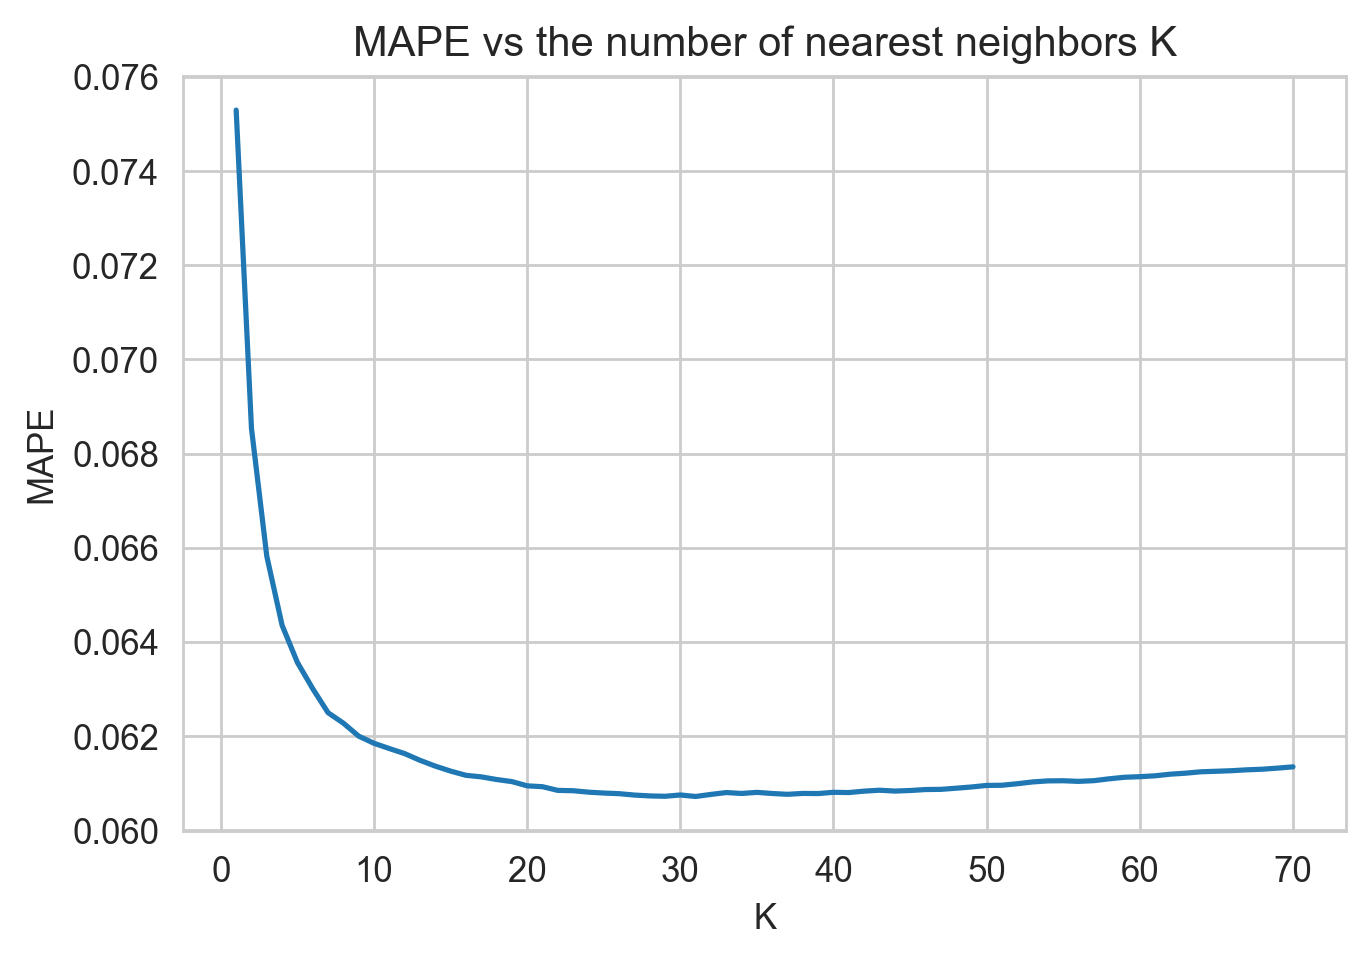

In [36]:
results = []
for i in range(1,71):
    knn = KNR(n_neighbors=i, weights="distance", metric="minkowski")
    knn.fit(train[features], train['price_per_m2_log'])
    pred = knn.predict(test[features])
    results.append(mape(test['price_per_m2_log'], pred))
from matplotlib import pyplot as plt
plt.figure(dpi=250)
plt.plot(range(1,71), results)
plt.xlabel("K")
plt.ylabel("MAPE")
plt.title("MAPE vs the number of nearest neighbors K")


In [37]:
train, dev = train_test_split(train, test_size=0.1)


In [40]:
from tensorflow import keras as ks
import tensorflow as tf
model = ks.Sequential()
model.add(ks.layers.Dense(30, input_dim = 21, activation = 'relu', name = 'input'))
model.add(ks.layers.Dropout(0.1))
model.add(ks.layers.Dense(1, name = 'output'))
opt = ks.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer = opt, 
              loss = tf.keras.losses.MeanSquaredLogarithmicError(), 
              metrics = ['mean_absolute_percentage_error'])
train_history = model.fit(train[features], train["price_per_m2"], batch_size = 512, epochs = 30, validation_split = 0.1)
ann_train_res = model.evaluate(dev[features], dev["price_per_m2"])
ann_test_res = model.evaluate(test[features], test["price_per_m2"])
print("Train:  Loss = %f, Mean_absolute percentage_error = %f" %(ann_train_res[0], ann_train_res[1]/100))
print("Test:  Loss = %f, Mean_absolute_perntage_error = %f" %(ann_test_res[0], ann_test_res[1]/100))


Epoch 1/30
30/30 [==============================] - 1s 12ms/step - loss: 9.1200 - mean_absolute_percentage_error: 92.1527 - val_loss: 3.1029 - val_mean_absolute_percentage_error: 80.8399
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 1.7481 - mean_absolute_percentage_error: 67.6930 - val_loss: 0.9124 - val_mean_absolute_percentage_error: 54.8031
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 0.6112 - mean_absolute_percentage_error: 45.2972 - val_loss: 0.4051 - val_mean_absolute_percentage_error: 38.1533
Epoch 4/30
30/30 [==============================] - 0s 5ms/step - loss: 0.3187 - mean_absolute_percentage_error: 34.4060 - val_loss: 0.2498 - val_mean_absolute_percentage_error: 32.0369
Epoch 5/30
30/30 [==============================] - 0s 5ms/step - loss: 0.2244 - mean_absolute_percentage_error: 31.4957 - val_loss: 0.1950 - val_mean_absolute_percentage_error: 30.9665
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - los

In [42]:
pred = model.predict(test[features])
print_metrics(test['price_per_m2'], pred, False) #Lower the better

283/283 [==============================] - 1s 2ms/step
R2: 0.217048844286848
RMSE: 137.74670834155813
MAPE: 0.42940719467329586
